In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords
import re
import string

In [34]:
true_news = pd.read_csv('data/True.csv')
fake_news = pd.read_csv('data/Fake.csv')

In [35]:
true_news['label'] = 0  # 0 for real news
fake_news['label'] = 1  # 1 for fake news

In [36]:
df = pd.concat([true_news, fake_news]).sample(frac=1, random_state=42).reset_index(drop=True)

In [37]:
df.head()

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",1
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",1
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",1
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",0
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",1


In [38]:
df = df.drop(['date','subject','title'],axis=1)

In [39]:
df.head()

,text,label
0,"Donald Trump s White House is in chaos, and th...",1
1,Now that Donald Trump is the presumptive GOP n...,1
2,Mike Pence is a huge homophobe. He supports ex...,1
3,SAN FRANCISCO (Reuters) - California Attorney ...,0
4,Twisted reasoning is all that comes from Pelos...,1


In [40]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def clr_text(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    text = " ".join(tokens)
    return text

df['text'] = df['text'].apply(clr_text)

[nltk_data] Downloading package stopwords to /home/junu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/junu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
df.head()

,text,label
0,"Donald Trump White House chaos, trying cover u...",1
1,"Now Donald Trump presumptive GOP nominee, time...",1
2,Mike Pence huge homophobe. He supports ex-gay ...,1
3,SAN FRANCISCO (Reuters) - California Attorney ...,0
4,Twisted reasoning comes Pelosi days especially...,1


In [42]:
vectorizer = TfidfVectorizer(max_features=5000) 
X = vectorizer.fit_transform(df['text'])
y = df['label']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [45]:
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.989086859688196
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4311
           1       0.99      0.99      0.99      4669

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



Confusion Matrix:
 [[4274   37]
 [  61 4608]]


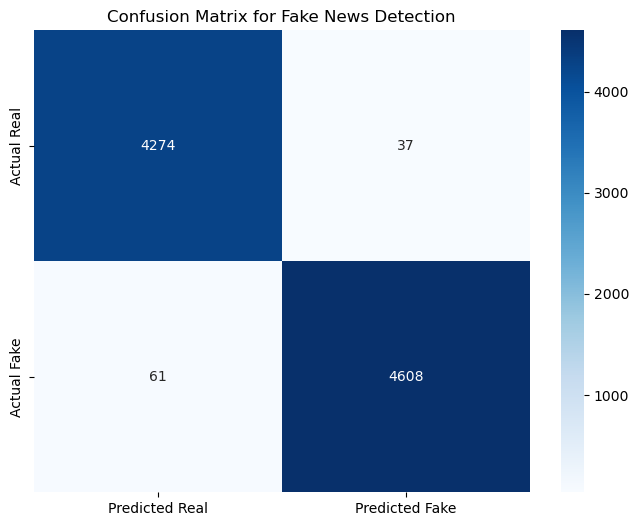

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])
plt.title('Confusion Matrix for Fake News Detection')
plt.show()

In [47]:
import joblib
joblib.dump(model, 'fake_news_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']